In [1]:
import sys,os
os.environ["JAX_ENABLE_X64"] = "true"
os.environ["JAX_PLATFORMS"] = "cpu"
from dadapy.hamming import *

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

/leonardo/home/userexternal/sacevedo/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


test_images shape: (5000, 784)
test_labels shape: (5000,)


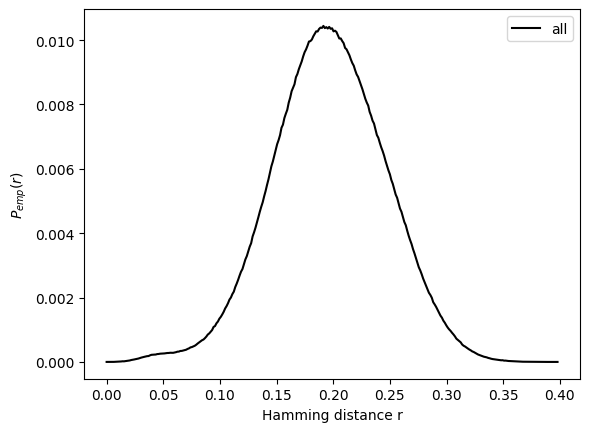

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
Ns = 5000
fig,ax = plt.subplots(1)


take_all = True
if take_all:

  # Load MNIST test set
  testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  # Extract images and labels for test set
  test_images = []
  test_labels = []

  for image, label in testset:
      test_images.append(image.numpy().flatten())
      test_labels.append(label)

  # Convert to NumPy arrays
  test_images = np.array(test_images)[:Ns]
  test_labels = np.array(test_labels)[:Ns]

  print(f"test_images shape: {test_images.shape}")
  print(f"test_labels shape: {test_labels.shape}")

  # fig,ax = plt.subplots(1)
  # ax.imshow(test_images[0].reshape((28,28)))
  # plt.show()
  X_all = 2*np.sign(test_images[:Ns]).astype(int)-1

filter = False
if filter:
  # Define transformation to convert images to tensor
  fixed_numbers = np.arange(1,9,2,dtype=int)
  fixed_numbers = [7]

  for fixed_number in fixed_numbers:
    # Load MNIST test set
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Filter the dataset to only keep images of the digit '7'
    filtered_images = []
    filtered_labels = []

    # Iterate through the testset and filter by label
    for image, label in testset:
        if label == fixed_number:  # Filter out only the digit '7'
            filtered_images.append(image.numpy().flatten())  # Flatten the image and add to the list
            filtered_labels.append(label)  # Add the label (which will be 7) to the list

    # Convert filtered lists to NumPy arrays
    filtered_images = np.array(filtered_images)  # Shape: (num_samples, 784)
    filtered_labels = np.array(filtered_labels)  # Shape: (num_samples,)

    # print(f"Filtered images shape: {filtered_images.shape}")
    # print(f"Filtered labels shape: {filtered_labels.shape}")

    X_f = 2*np.sign(filtered_images[:Ns]).astype(int)-1

    H = Hamming(coordinates=X_f)
    H.compute_distances()
    histfolder = f'results/BID/hist/{label}/Ns{Ns}/'
    H.D_histogram(compute_flag=1,
                  save=1,
                  resultsfolder=histfolder,
                  )

    ax.plot(H.D_values/X_f.shape[1],H.D_probs,label=f'{fixed_number}')
    ax.set_yscale('log')
    ax.set_xscale('log')


if take_all:
  H = Hamming(coordinates=X_all)
  H.compute_distances()
  histfolder0 = f'results/BID/hist/'

  histfolder = f'{histfolder0}all'
  H.D_histogram(compute_flag=1,
                save=1,
                resultsfolder=histfolder + f'Ns{Ns}/',
                )

  ax.plot(H.D_values/X_all.shape[1],H.D_probs,label=f'all',color='black')
ax.legend()
ax.set_xlabel('Hamming distance r')
ax.set_ylabel(r'$P_{emp}(r)$')

plt.show()

In [16]:
alphamin = 0 #1E-5
alphamax = 5E-3
delta = 5E-4
Nsteps = int(3E5)
seed = 1
take_all = False

_optfolder = f'results/BID/opt/'
if take_all:
    _optfolder += f'all/'
elif filter:
    _optfolder += f'{label}/'
optfolder0 = _optfolder + f'Ns{Ns}/'

B = BID(H,
        alphamin=alphamin,
        alphamax=alphamax,
        seed=seed,
        delta=delta,
        Nsteps=Nsteps,
        optfolder0=optfolder0,
        )
B.computeBID()

starting optimization
optimization took 0.1 minutes
d_0=19.678,d_1=1.667,logKL=-6.65


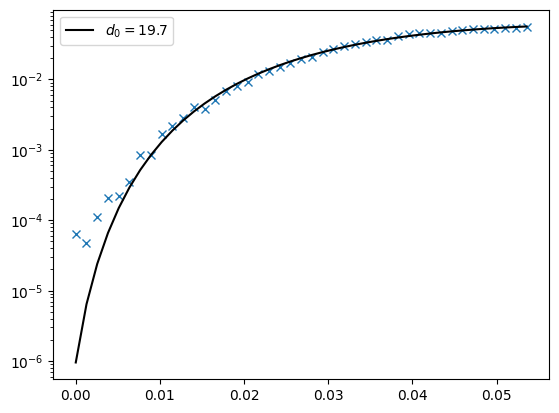

In [17]:
fig,ax=plt.subplots(1)

B = BID(
          alphamin=alphamin,
          alphamax=alphamax,
          seed=seed,
          delta=delta,
          Nsteps=Nsteps,
          optfolder0=optfolder0,
          )
remp,Pemp,Pmodel = B.load_fit()
rmax,sigma,alpha,logKL = B.load_results()

ax.plot(remp/X_all.shape[1],
          Pemp,
          'x',
          # label=f'{T=:.2f}',
          zorder=0,
          )
if logKL < np.inf:
  ax.plot(remp/X_all.shape[1],
        Pmodel,
         label= r'$d_0=$' + f'{sigma:.1f}',
        zorder=1,
        color='black',
        )

if filter:
  ax.set_title(f'{fixed_number}')
ax.legend()
ax.set_yscale('log')
plt.show()